In [ ]:

!pip install pyspark -q
!pip install aquarel -q
!pip install statsmodels -q
!pip install plotly -q
!pip install scikit-learn -q
!pip install xgboost -q

In [ ]:

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as fn
from pyspark.sql.functions import countDistinct, year, month, avg, to_date, initcap, trim, col, when, lag, count
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aquarel import load_theme
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor  # Import XGBoost
import warnings
import tensorflow as tf




warnings.filterwarnings("ignore")


sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName('Healthcare Dataset - ML Forecasting').getOrCreate()


In [ ]:

print("Loading raw data...")
healthcare_raw = spark.read.csv('/content/sample_data/healthcare_dataset.csv', header=True, inferSchema=True)

print("Starting data preprocessing...")


print(" - Cleaning text columns...")
text_columns = ["Name", "Gender", "Blood Type", "Medical Condition", "Insurance Provider", "Test Results", "Admission Type"]
for col_name in text_columns:
    healthcare_raw = healthcare_raw.withColumn(col_name, initcap(trim(col(col_name))))


print(" - Converting date columns...")
healthcare_raw = healthcare_raw.withColumn("Date of Admission", to_date(col("Date of Admission"), "yyyy-MM-dd"))
healthcare_raw = healthcare_raw.withColumn("Discharge Date", to_date(col("Discharge Date"), "yyyy-MM-dd"))


print(" - Handling invalid Billing Amount...")
healthcare_raw = healthcare_raw.withColumn("Billing Amount",
    when(col("Billing Amount") < 0, None).otherwise(col("Billing Amount"))
)


print(" - Dropping rows with invalid admission dates...")
healthcare = healthcare_raw.dropna(subset=["Date of Admission"])

print("Preprocessing completed.")
print(f"Original rows: {healthcare_raw.count()} | Cleaned rows: {healthcare.count()}")


Loading raw data...
Starting data preprocessing...
 - Cleaning text columns...
 - Converting date columns...
 - Handling invalid Billing Amount...
 - Dropping rows with invalid admission dates...
Preprocessing completed.
Original rows: 55500 | Cleaned rows: 55500


In [ ]:


print("Aggregating monthly average admissions...")


daily_admissions = healthcare\
    .groupBy("Date of Admission", "Medical Condition") \
    .agg(countDistinct("Name").alias("Daily Admissions"))


agg_healthcare_month_avg = daily_admissions\
    .withColumn("Month", month("Date of Admission")) \
    .groupBy("Month", "Medical Condition") \
    .agg(avg("Daily Admissions").alias("Average Daily Admissions")) \
    .sort("Month")

print("Aggregating yearly total admissions...")
agg_healthcare_year_total = healthcare\
    .groupBy(year("Date of Admission").alias("Year"), "Medical Condition") \
    .agg(countDistinct("Name").alias("Total Yearly Admissions"))\
    .sort("Year")


agg_pd_df_month_avg = agg_healthcare_month_avg.toPandas()
agg_pd_df_month_avg['Month'] = agg_pd_df_month_avg['Month'].astype(int)
agg_pd_df_year_total = agg_healthcare_year_total.toPandas()
agg_pd_df_year_total['Year'] = agg_pd_df_year_total['Year'].astype(int)

conditions = agg_pd_df_month_avg['Medical Condition'].unique()

Aggregating monthly average admissions...
Aggregating yearly total admissions...


In [ ]:



model_performance = {
    'Condition': [],
    'Model': [],
    'MAE': [],
    'RMSE': []
}


arima_forecast_results = []
rf_forecast_results = []
xgb_forecast_results = []
forecast_steps = 3

print("Starting modeling and forecasting for each condition...")

for condition in conditions:
    print(f"\n--- Processing Condition: {condition} ---")
    df_condition = agg_pd_df_month_avg[agg_pd_df_month_avg['Medical Condition'] == condition][['Month', 'Average Daily Admissions']].copy()
    df_condition = df_condition.sort_values('Month').reset_index(drop=True)


    if len(df_condition) < 6:
        print(f"   Skipping {condition}: Insufficient data points (< 6).")
        continue


    train_size = len(df_condition) - 3 if len(df_condition) > 3 else len(df_condition) - 1
    if train_size < 1:
        print(f"   Skipping {condition}: Insufficient data for train-test split.")
        continue

    train_df = df_condition.iloc[:train_size]
    test_df = df_condition.iloc[train_size:]


    y_test = test_df['Average Daily Admissions'].values

    # ARIMA
    print("   Fitting ARIMA...")
    arima_mae, arima_rmse = np.nan, np.nan
    arima_forecast = None
    try:

        arima_model_train = ARIMA(train_df['Average Daily Admissions'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
        arima_fit_train = arima_model_train.fit()

        arima_pred = arima_fit_train.forecast(steps=len(test_df))
        arima_mae = mean_absolute_error(y_test, arima_pred)
        arima_rmse = np.sqrt(mean_squared_error(y_test, arima_pred))


        arima_model_full = ARIMA(df_condition['Average Daily Admissions'], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
        arima_fit_full = arima_model_full.fit()
        arima_forecast = arima_fit_full.forecast(steps=forecast_steps)


        forecast_months = [df_condition['Month'].max() + i + 1 for i in range(forecast_steps)]
        arima_forecast_df = pd.DataFrame({
            'Month': forecast_months,
            'Average Daily Admissions': arima_forecast,
            'Medical Condition': condition,
            'Type': 'ARIMA_Forecast'
        })
        arima_forecast_results.append(arima_forecast_df)

        print(f"   ARIMA MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}")

    except Exception as e:
        print(f"   ARIMA failed for {condition}: {e}")


    model_performance['Condition'].append(condition)
    model_performance['Model'].append('ARIMA')
    model_performance['MAE'].append(arima_mae)
    model_performance['RMSE'].append(arima_rmse)

    # RANDOM FOREST
    print("   Fitting Random Forest...")
    rf_mae, rf_rmse = np.nan, np.nan
    rf_forecast = None
    try:

        df_rf = df_condition.copy()
        for lag in range(1, 4):
            df_rf[f'lag_{lag}'] = df_rf['Average Daily Admissions'].shift(lag)

        df_rf = df_rf.dropna().reset_index(drop=True)

        if len(df_rf) < 2:
            raise ValueError("Insufficient data after creating lag features.")

        adjusted_train_size = train_size - 3
        if adjusted_train_size < 1 or adjusted_train_size >= len(df_rf):
            raise ValueError("Adjusted train size invalid.")

        train_rf = df_rf.iloc[:adjusted_train_size]
        test_rf = df_rf.iloc[adjusted_train_size:]

        feature_cols = [f'lag_{i}' for i in range(1, 4)]
        X_train = train_rf[feature_cols]
        y_train = train_rf['Average Daily Admissions']
        X_test = test_rf[feature_cols]
        y_test_rf = test_rf['Average Daily Admissions']

        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        rf_pred = rf_model.predict(X_test)
        rf_mae = mean_absolute_error(y_test_rf, rf_pred)
        rf_rmse = np.sqrt(mean_squared_error(y_test_rf, rf_pred))


        last_known = df_condition['Average Daily Admissions'].iloc[-3:].values[::-1]
        rf_forecast = []
        current_input = last_known.copy()

        for _ in range(forecast_steps):
            pred = rf_model.predict(current_input.reshape(1, -1))[0]
            rf_forecast.append(pred)
            current_input = np.roll(current_input, -1)
            current_input[-1] = pred

        forecast_months = [df_condition['Month'].max() + i + 1 for i in range(forecast_steps)]
        rf_forecast_df = pd.DataFrame({
            'Month': forecast_months,
            'Average Daily Admissions': rf_forecast,
            'Medical Condition': condition,
            'Type': 'RF_Forecast'
        })
        rf_forecast_results.append(rf_forecast_df)

        print(f"   RF MAE: {rf_mae:.4f}, RMSE: {rf_rmse:.4f}")

    except Exception as e:
        print(f"   Random Forest failed for {condition}: {e}")


    model_performance['Condition'].append(condition)
    model_performance['Model'].append('Random Forest')
    model_performance['MAE'].append(rf_mae)
    model_performance['RMSE'].append(rf_rmse)


  #XGBoost

    print("   Fitting XGBoost...")
    xgb_mae, xgb_rmse = np.nan, np.nan
    xgb_forecast = None
    try:

        if 'df_rf' not in locals() or len(df_rf) < 2:
            raise ValueError("Lagged data not available or insufficient.")

        X_train_xgb = X_train
        y_train_xgb = y_train
        X_test_xgb = X_test
        y_test_xgb = y_test_rf


        xgb_model = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
        xgb_model.fit(X_train_xgb, y_train_xgb)


        xgb_pred = xgb_model.predict(X_test_xgb)
        xgb_mae = mean_absolute_error(y_test_xgb, xgb_pred)
        xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, xgb_pred))


        last_known = df_condition['Average Daily Admissions'].iloc[-3:].values[::-1]
        xgb_forecast = []
        current_input = last_known.copy()

        for _ in range(forecast_steps):
            pred = xgb_model.predict(current_input.reshape(1, -1))[0]
            xgb_forecast.append(pred)
            current_input = np.roll(current_input, -1)
            current_input[-1] = pred


        forecast_months = [df_condition['Month'].max() + i + 1 for i in range(forecast_steps)]
        xgb_forecast_df = pd.DataFrame({
            'Month': forecast_months,
            'Average Daily Admissions': xgb_forecast,
            'Medical Condition': condition,
            'Type': 'XGB_Forecast'
        })
        xgb_forecast_results.append(xgb_forecast_df)

        print(f"   XGBoost MAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}")

    except Exception as e:
        print(f"   XGBoost failed for {condition}: {e}")


    model_performance['Condition'].append(condition)
    model_performance['Model'].append('XGBoost')
    model_performance['MAE'].append(xgb_mae)
    model_performance['RMSE'].append(xgb_rmse)

Starting modeling and forecasting for each condition...

--- Processing Condition: Hypertension ---
   Fitting ARIMA...
   ARIMA MAE: 0.0727, RMSE: 0.0820
   Fitting Random Forest...
   RF MAE: 0.0504, RMSE: 0.0565
   Fitting XGBoost...
   XGBoost MAE: 0.0697, RMSE: 0.0905

--- Processing Condition: Asthma ---
   Fitting ARIMA...
   ARIMA MAE: 0.5023, RMSE: 0.5077
   Fitting Random Forest...
   RF MAE: 0.2940, RMSE: 0.3179
   Fitting XGBoost...
   XGBoost MAE: 0.4097, RMSE: 0.4327

--- Processing Condition: Diabetes ---
   Fitting ARIMA...
   ARIMA MAE: 0.1265, RMSE: 0.1364
   Fitting Random Forest...
   RF MAE: 0.2281, RMSE: 0.2432
   Fitting XGBoost...
   XGBoost MAE: 0.2585, RMSE: 0.2661

--- Processing Condition: Obesity ---
   Fitting ARIMA...
   ARIMA MAE: 0.1450, RMSE: 0.1588
   Fitting Random Forest...
   RF MAE: 0.1274, RMSE: 0.1353
   Fitting XGBoost...
   XGBoost MAE: 0.1586, RMSE: 0.1630

--- Processing Condition: Arthritis ---
   Fitting ARIMA...
   ARIMA MAE: 0.1013, RMSE

In [ ]:

actual_dfs = []
for condition in conditions:
    df_condition = agg_pd_df_month_avg[agg_pd_df_month_avg['Medical Condition'] == condition][['Month', 'Average Daily Admissions']].copy()
    df_condition['Medical Condition'] = condition
    df_condition['Type'] = 'Actual'
    actual_dfs.append(df_condition)

all_actual_df = pd.concat(actual_dfs, ignore_index=True)
all_forecast_dfs = []

if arima_forecast_results:
    all_forecast_dfs.append(pd.concat(arima_forecast_results, ignore_index=True))
if rf_forecast_results:
    all_forecast_dfs.append(pd.concat(rf_forecast_results, ignore_index=True))
if xgb_forecast_results:
    all_forecast_dfs.append(pd.concat(xgb_forecast_results, ignore_index=True))

if all_forecast_dfs:
    all_forecast_df = pd.concat(all_forecast_dfs, ignore_index=True)
    combined_plot_df = pd.concat([all_actual_df, all_forecast_df], ignore_index=True)
else:
    combined_plot_df = all_actual_df


print("\n\n" + "="*80)
print("FORECASTED DATA FOR THE NEXT 3 MONTHS")
print("="*80)

if arima_forecast_results:
    print("\n--- ARIMA FORECASTS ---")
    arima_forecasts_df = pd.concat(arima_forecast_results, ignore_index=True)
    print(arima_forecasts_df.to_string(index=False))

if rf_forecast_results:
    print("\n--- RANDOM FOREST FORECASTS ---")
    rf_forecasts_df = pd.concat(rf_forecast_results, ignore_index=True)
    print(rf_forecasts_df.to_string(index=False))

if xgb_forecast_results:
    print("\n--- XGBOOST FORECASTS ---")
    xgb_forecasts_df = pd.concat(xgb_forecast_results, ignore_index=True)
    print(xgb_forecasts_df.to_string(index=False))



FORECASTED DATA FOR THE NEXT 3 MONTHS

--- ARIMA FORECASTS ---
 Month  Average Daily Admissions Medical Condition           Type
    13                  4.604827      Hypertension ARIMA_Forecast
    14                  4.598796      Hypertension ARIMA_Forecast
    15                  4.596835      Hypertension ARIMA_Forecast
    13                  4.524102            Asthma ARIMA_Forecast
    14                  4.564857            Asthma ARIMA_Forecast
    15                  4.578829            Asthma ARIMA_Forecast
    13                  4.642568          Diabetes ARIMA_Forecast
    14                  4.627744          Diabetes ARIMA_Forecast
    15                  4.628857          Diabetes ARIMA_Forecast
    13                  4.490814           Obesity ARIMA_Forecast
    14                  4.698116           Obesity ARIMA_Forecast
    15                  4.551696           Obesity ARIMA_Forecast
    13                  4.823832         Arthritis ARIMA_Forecast
    14     

In [ ]:

performance_df = pd.DataFrame(model_performance)
print("\n\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON (MAE & RMSE)")
print("="*80)
print(performance_df.to_string(index=False))



MODEL PERFORMANCE COMPARISON (MAE & RMSE)
   Condition         Model      MAE     RMSE
Hypertension         ARIMA 0.072733 0.082007
Hypertension Random Forest 0.050450 0.056532
Hypertension       XGBoost 0.069710 0.090499
      Asthma         ARIMA 0.502328 0.507672
      Asthma Random Forest 0.294010 0.317855
      Asthma       XGBoost 0.409663 0.432719
    Diabetes         ARIMA 0.126520 0.136422
    Diabetes Random Forest 0.228130 0.243202
    Diabetes       XGBoost 0.258503 0.266075
     Obesity         ARIMA 0.145009 0.158839
     Obesity Random Forest 0.127376 0.135296
     Obesity       XGBoost 0.158574 0.163047
   Arthritis         ARIMA 0.101325 0.109920
   Arthritis Random Forest 0.108618 0.116295
   Arthritis       XGBoost 0.075819 0.097980
      Cancer         ARIMA 0.160215 0.173711
      Cancer Random Forest 0.153617 0.188368
      Cancer       XGBoost 0.175672 0.210854


In [ ]:

avg_performance = performance_df.groupby('Model')[['MAE', 'RMSE']].mean()
print("\n--- AVERAGE PERFORMANCE ACROSS CONDITIONS ---")
print(avg_performance.to_string())


--- AVERAGE PERFORMANCE ACROSS CONDITIONS ---
                    MAE      RMSE
Model                            
ARIMA          0.184688  0.194762
Random Forest  0.160367  0.176258
XGBoost        0.191323  0.210196


In [ ]:

theme = load_theme("arctic_light")
theme.apply()
plt.rcParams['font.family'] = 'DejaVu Sans'


if not combined_plot_df.empty:
    fig = px.line(
        combined_plot_df,
        x="Month",
        y="Average Daily Admissions",
        color='Medical Condition',
        line_dash='Type',
        title="Actual vs Forecasted Average Daily Admissions (ARIMA, RF, XGBoost)"
    )
    fig.show()

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = avg_performance.index
mae_values = avg_performance['MAE']
rmse_values = avg_performance['RMSE']

axes[0].bar(models, mae_values, color=['blue', 'green', 'orange'])  # Orange for XGBoost
axes[0].set_title('Average MAE Comparison')
axes[0].set_ylabel('Mean Absolute Error (MAE)')
axes[0].grid(axis='y')

axes[1].bar(models, rmse_values, color=['red', 'yellow', 'purple'])
axes[1].set_title('Average RMSE Comparison')
axes[1].set_ylabel('Root Mean Squared Error (RMSE)')
axes[1].grid(axis='y')


plt.show()

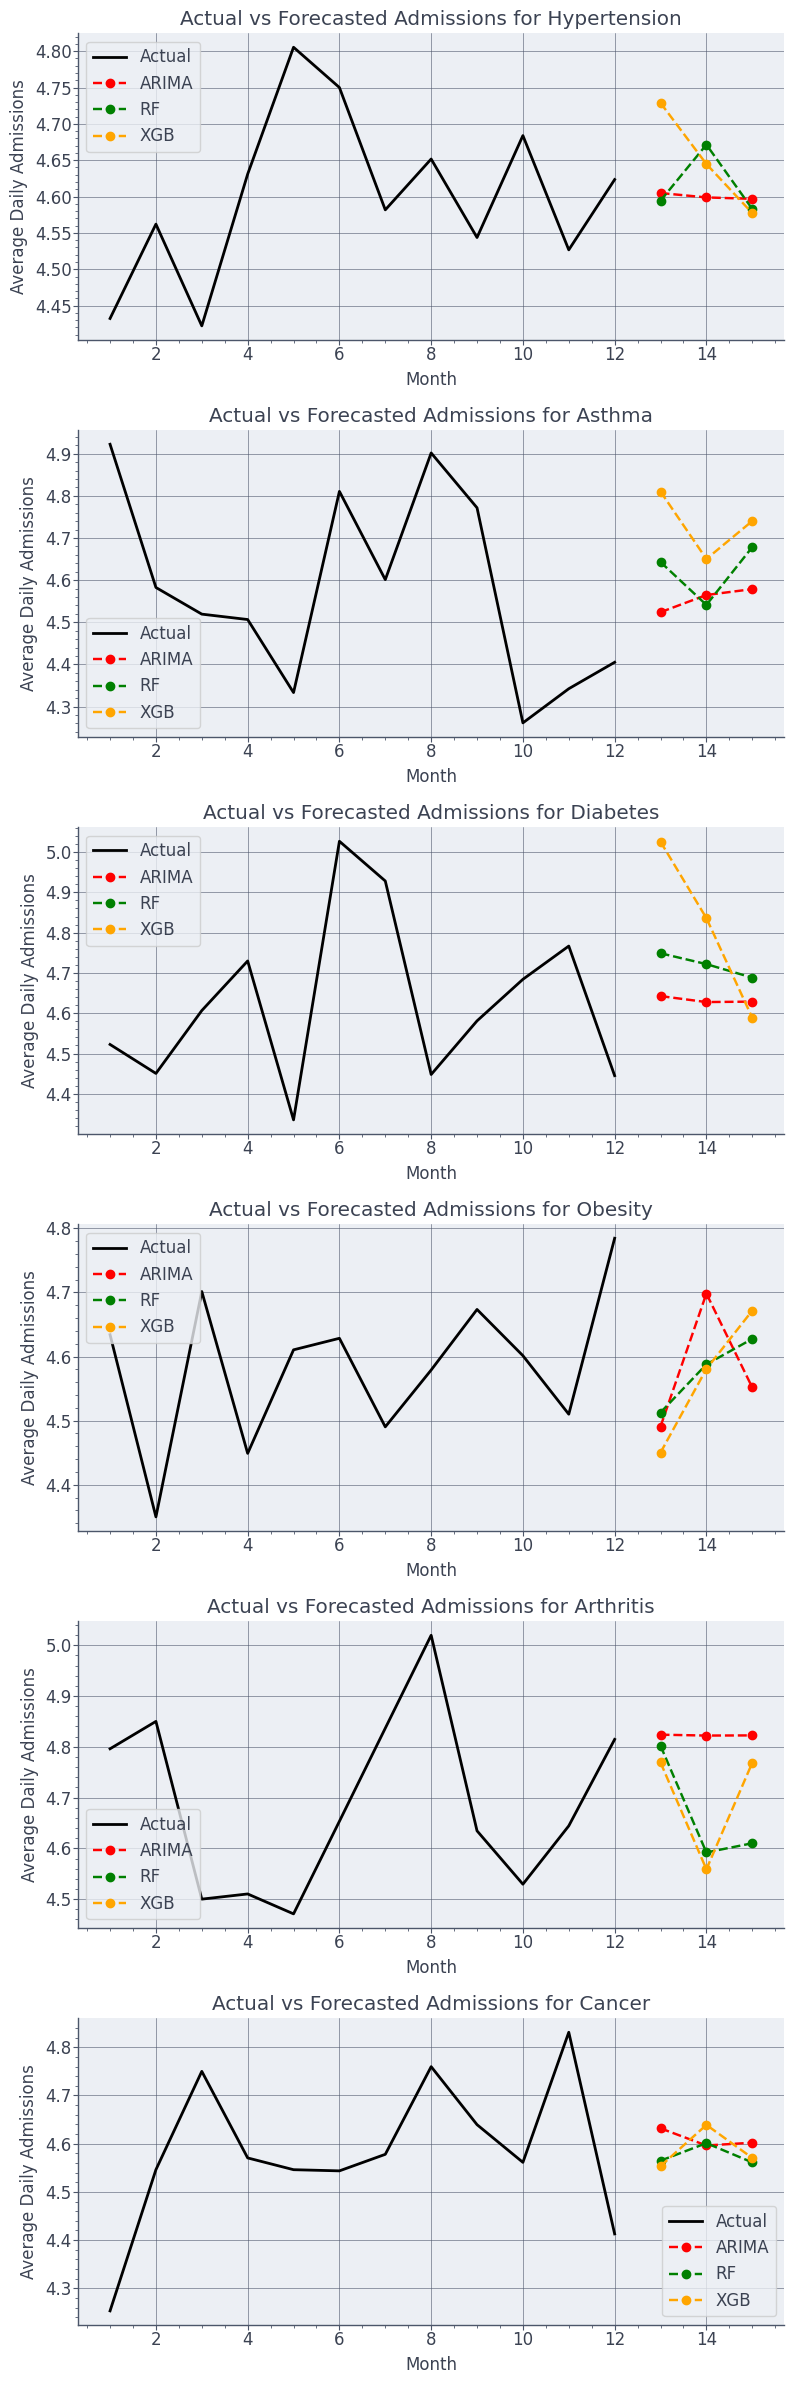


Analysis and forecasting pipeline completed successfully.


In [ ]:





num_conditions = len(conditions)
if num_conditions > 0:
    fig, axes = plt.subplots(num_conditions, 1, figsize=(8, 4*num_conditions))

    for i, condition in enumerate(conditions):
        df_plot = combined_plot_df[combined_plot_df['Medical Condition'] == condition]
        ax = axes[i] if num_conditions > 1 else axes

        actual_data = df_plot[df_plot['Type'] == 'Actual']
        ax.plot(actual_data['Month'], actual_data['Average Daily Admissions'], label='Actual', color='black', linewidth=2)


        colors = {'ARIMA_Forecast': 'red', 'RF_Forecast': 'green', 'XGB_Forecast': 'orange'}
        for forecast_type in ['ARIMA_Forecast', 'RF_Forecast', 'XGB_Forecast']:
            forecast_data = df_plot[df_plot['Type'] == forecast_type]
            if not forecast_data.empty:
                ax.plot(forecast_data['Month'], forecast_data['Average Daily Admissions'],
                        label=forecast_type.replace('_Forecast', ''), color=colors[forecast_type], linestyle='--', marker='o')

        ax.set_title(f'Actual vs Forecasted Admissions for {condition}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Average Daily Admissions')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

theme.apply_transforms()

print("\nAnalysis and forecasting pipeline completed successfully.")